In [3]:
from google.colab import files
uploaded = files.upload()  # This opens a file picker UI in the browser.


Saving train.csv to train.csv


In [4]:
# Cell 1: Install Libraries and Import necessary modules

!pip install nltk
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Download NLTK data (run this only once)
try:
    nltk.data.find('tokenizers/punkt')
    print("NLTK punkt tokenizer already downloaded.")
except LookupError:
    print("Downloading NLTK punkt tokenizer...")
    nltk.download('punkt')
    print("NLTK punkt tokenizer downloaded.")

# Try downloading punkt_tab specifically if needed
try:
    nltk.data.find('tokenizers/punkt_tab')
    print("NLTK punkt_tab tokenizer already downloaded.")
except LookupError:
    print("Downloading NLTK punkt_tab tokenizer...")
    nltk.download('punkt_tab')
    print("NLTK punkt_tab tokenizer downloaded.")


# Download stopwords
try:
    nltk.data.find('corpora/stopwords')
    print("NLTK stopwords already downloaded.")
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords')
    print("NLTK stopwords downloaded.")

# Download Porter Stemmer
try:
    nltk.data.find('stemmers/porter')
    print("NLTK Porter Stemmer already downloaded.")
except LookupError:
    print("Downloading NLTK Porter Stemmer...")
    nltk.download('porter_stemmer')
    print("NLTK Porter Stemmer downloaded.")


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression # Reverting to Logistic Regression
from sklearn.metrics import classification_report, accuracy_score

NLTK punkt tokenizer already downloaded.
NLTK punkt_tab tokenizer downloaded.
NLTK stopwords already downloaded.
NLTK Porter Stemmer downloaded.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Error loading porter_stemmer: Package 'porter_stemmer' not
[nltk_data]     found in index


In [5]:
# Cell 2: Load the Dataset

# Load the CSV file (assuming it's named train.csv and is in the default directory)
# If your file has a different name or is in a subdirectory, adjust the path accordingly.
try:
    train_df = pd.read_csv("train.csv", encoding='latin-1') # Added encoding just in case
    print("Successfully loaded train.csv")
    print("\nFirst 5 rows of the dataset:")
    print(train_df.head())
    print("\nMissing values per column:")
    print(train_df.isnull().sum())
    print("\nColumn names:")
    print(train_df.columns.tolist()) # Print columns as a list for clarity

except FileNotFoundError:
    print("Error: train.csv not found. Please make sure you have uploaded the file to your Colab environment.")
    # You might want to stop execution here if the file is essential
    # In a script, you would use exit() or raise an exception.
    # In a notebook, you can just observe the error and fix the upload.

Successfully loaded train.csv

First 5 rows of the dataset:
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Time of Tweet Age of User  \
0  I`d have responded, if I were going   neutral       morning        0-20   
1                             Sooo SAD  negative          noon       21-30   
2                          bullying me  negative         night       31-45   
3                       leave me alone  negative       morning       46-60   
4                        Sons of ****,  negative          noon       60-70   

       Country  Population -2020  Land Area (Km²)  Density (P/

In [6]:
# Cell 3: Identify Column Names and Map Sentiment (Adjust as needed)

# --- Adjust these column names based on your train.csv file ---
# Use the output from the previous cell's print(train_df.columns.tolist())
text_column_name = 'text'      # Replace with your actual text column name
sentiment_column_name = 'sentiment' # Replace with your actual sentiment column name

if text_column_name in train_df.columns and sentiment_column_name in train_df.columns:
    print(f"\nUsing '{text_column_name}' for text and '{sentiment_column_name}' for sentiment.")

    # Map sentiment labels to numerical values
    # Adjust the mapping based on the sentiment values in your dataset
    # Based on common sentiment datasets, it might be 'positive', 'negative', 'neutral'
    # Let's set up a map for those, you can adjust if your labels are different.
    sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2} # Adjust this based on your sentiment values

    train_df['sentiment_numerical'] = train_df[sentiment_column_name].map(sentiment_map)

    # Drop rows with missing values in the relevant columns
    # Also drop rows where sentiment mapping resulted in NaN (if any unknown values)
    initial_rows = len(train_df)
    train_df.dropna(subset=[text_column_name, 'sentiment_numerical'], inplace=True)
    rows_after_drop = len(train_df)
    if initial_rows > rows_after_drop:
        print(f"\nDropped {initial_rows - rows_after_drop} rows with missing values.")


    print("\nFirst 5 rows with numerical sentiment:")
    print(train_df[[text_column_name, sentiment_column_name, 'sentiment_numerical']].head())

else:
    print(f"\nError: Dataset does not contain '{text_column_name}' and '{sentiment_column_name}' columns as expected.")
    print("Please check the 'Column names:' output from the previous cell and update the variables 'text_column_name' and 'sentiment_column_name' in this cell.")
    # Consider stopping execution here if the necessary columns are not found.


Using 'text' for text and 'sentiment' for sentiment.

Dropped 1 rows with missing values.

First 5 rows with numerical sentiment:
                                                text sentiment  \
0                I`d have responded, if I were going   neutral   
1      Sooo SAD I will miss you here in San Diego!!!  negative   
2                          my boss is bullying me...  negative   
3                     what interview! leave me alone  negative   
4   Sons of ****, why couldn`t they put them on t...  negative   

   sentiment_numerical  
0                    1  
1                    0  
2                    0  
3                    0  
4                    0  


In [7]:
# Cell 4: Text Cleaning

# Ensure the necessary columns exist before proceeding
if 'sentiment_numerical' in train_df.columns and text_column_name in train_df.columns:

    from nltk.stem.porter import PorterStemmer
    porter = PorterStemmer()

    def clean_text(text):
        # Ensure the input is a string before processing
        if not isinstance(text, str):
            return ""
        text = text.lower() # Convert to lowercase
        text = re.sub(r'[^a-z\s]', '', text) # Remove non-alphabetic characters
        tokens = word_tokenize(text) # Tokenize
        tokens = [word for word in tokens if word not in stopwords.words('english')] # Remove stop words
        # Add Stemming
        tokens = [porter.stem(word) for word in tokens]
        return ' '.join(tokens)

    # Apply cleaning to the text column
    train_df['cleaned_text'] = train_df[text_column_name].apply(clean_text)

    print("\nFirst 5 rows with cleaned text:")
    print(train_df[[text_column_name, 'cleaned_text']].head())
else:
    print("\nSkipping text cleaning: Required columns ('sentiment_numerical' or text column) not found.")


First 5 rows with cleaned text:
                                                text  \
0                I`d have responded, if I were going   
1      Sooo SAD I will miss you here in San Diego!!!   
2                          my boss is bullying me...   
3                     what interview! leave me alone   
4   Sons of ****, why couldn`t they put them on t...   

                            cleaned_text  
0                          id respond go  
1                sooo sad miss san diego  
2                             boss bulli  
3                    interview leav alon  
4  son couldnt put releas alreadi bought  


In [8]:
# Cell 5: Split Data and Vectorize Text

# Ensure 'cleaned_text' and 'sentiment_numerical' columns exist before proceeding
if 'cleaned_text' in train_df.columns and 'sentiment_numerical' in train_df.columns:
    print("\nSplitting data and vectorizing text...")

    X = train_df['cleaned_text']
    y = train_df['sentiment_numerical']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Vectorize text data using TF-IDF with bigrams
    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) # Added ngram_range=(1, 2)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    print(f"Shape of X_train_vec: {X_train_vec.shape}")
    print(f"Shape of X_test_vec: {X_test_vec.shape}")

else:
     print("\nSkipping data splitting and vectorization: Required columns ('cleaned_text' or 'sentiment_numerical') not found.")


Splitting data and vectorizing text...
Shape of X_train_vec: (21984, 10000)
Shape of X_test_vec: (5496, 10000)


In [10]:
# Cell 6: Train Multiple Models and Store Results - MODIFIED
# Ensure vectorization was successful and data exists before training
if 'X_train_vec' in locals() and X_train_vec is not None and 'y_train' in locals() and y_train is not None and X_train_vec.shape[0] > 0 and y_train.shape[0] > 0:
    print("\nTraining multiple models...")

    # Define the models to compare
    # You can choose 5 models from the ones imported in Cell 1
    models = {
        "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42), # Increased max_iter
        "Multinomial Naive Bayes": MultinomialNB(),
        "Linear SVM": LinearSVC(max_iter=10000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42)
        # You could add KNeighborsClassifier() here if you want 6 models
    }

    results = {} # Dictionary to store accuracy results
    trained_models = {} # Dictionary to store the trained model objects

    for name, model in models.items():
        print(f"Training {name}...")
        try:
            model.fit(X_train_vec, y_train)
            y_pred = model.predict(X_test_vec)
            accuracy = accuracy_score(y_test, y_pred)
            results[name] = accuracy
            trained_models[name] = model # Store the trained model
            print(f"{name} Accuracy: {accuracy:.4f}")
        except Exception as e:
            print(f"Error training {name}: {e}")
            results[name] = None # Indicate training failed

    # Find the best model (only among successfully trained models)
    successful_results = {name: acc for name, acc in results.items() if acc is not None}
    if successful_results:
        best_model_name = max(successful_results, key=successful_results.get)
        best_model = trained_models[best_model_name]
        print(f"\nBest model: {best_model_name} with accuracy: {results[best_model_name]:.4f}")
    else:
        print("\nNo models were successfully trained.")
        best_model_name = None
        best_model = None

else:
    print("\nSkipping model training: Vectorized training data not available or is empty.")
    best_model_name = None
    best_model = None
    results = {} # Ensure results dictionary is empty


Training multiple models...
Training Logistic Regression...
Logistic Regression Accuracy: 0.6845
Training Multinomial Naive Bayes...
Multinomial Naive Bayes Accuracy: 0.6328
Training Linear SVM...
Linear SVM Accuracy: 0.6689
Training Decision Tree...
Decision Tree Accuracy: 0.6459
Training Random Forest...
Random Forest Accuracy: 0.6976

Best model: Random Forest with accuracy: 0.6976



Evaluating the best model: Random Forest

Accuracy: 0.6975982532751092

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.59      0.65      1572
           1       0.66      0.72      0.68      2236
           2       0.74      0.77      0.75      1688

    accuracy                           0.70      5496
   macro avg       0.71      0.69      0.70      5496
weighted avg       0.70      0.70      0.70      5496


Generating accuracy visualization...


/tmp/ipython-input-3430188673.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_series.index, y=accuracy_series.values, palette='viridis') # Added a color palette


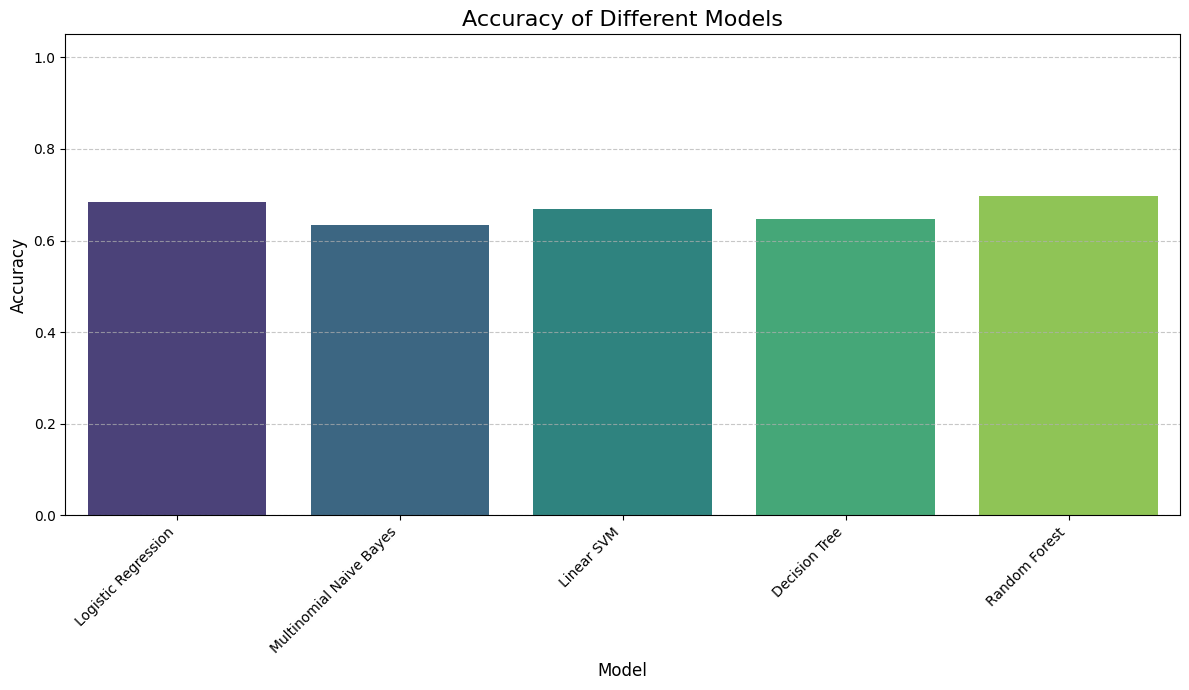

In [12]:
# Cell 7: Evaluate the Best Model (using the best model found in Cell 6)

# Ensure the best model was found and test data is available
if 'best_model' in locals() and best_model is not None and 'X_test_vec' in locals() and X_test_vec is not None and 'y_test' in locals() and y_test is not None and X_test_vec.shape[0] > 0 and y_test.shape[0] > 0:
    print(f"\nEvaluating the best model: {best_model_name}")

    try:
        y_pred_best = best_model.predict(X_test_vec)

        # Evaluate the best model
        print("\nAccuracy:", accuracy_score(y_test, y_pred_best))
        print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
    except Exception as e:
        print(f"Error evaluating best model: {e}")


else:
    print("\nSkipping best model evaluation: Best model or test data not available or is empty.")

# Cell 8: Visualize Model Accuracies

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure results were generated and are not empty
if 'results' in locals() and results:
    print("\nGenerating accuracy visualization...")

    # Filter out None values in results (for models that failed to train)
    plottable_results = {name: acc for name, acc in results.items() if acc is not None}

    if plottable_results:
        # Create a pandas Series for easier plotting
        accuracy_series = pd.Series(plottable_results)

        plt.figure(figsize=(12, 7)) # Increased figure size
        sns.barplot(x=accuracy_series.index, y=accuracy_series.values, palette='viridis') # Added a color palette
        plt.title('Accuracy of Different Models', fontsize=16) # Increased title font size
        plt.ylabel('Accuracy', fontsize=12)
        plt.xlabel('Model', fontsize=12)
        plt.ylim(0, 1.05) # Set y-axis limit from 0 to slightly above 1
        plt.xticks(rotation=45, ha='right', fontsize=10) # Rotate x-axis labels for better readability, adjusted font size
        plt.yticks(fontsize=10) # Adjusted y-axis font size
        plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a horizontal grid
        plt.tight_layout() # Adjust layout to prevent labels from overlapping
        plt.show()
    else:
         print("\nSkipping accuracy visualization: No successful model results to plot.")

else:
    print("\nSkipping accuracy visualization: No model results available.")

In [15]:
# Cell 8: Predict Sentiment of Real-time Input

# Make sure you have run all previous cells (1-7) successfully
# This cell assumes you have a trained 'model' and a fitted 'vectorizer'
# It also uses the clean_text function and sentiment_map from previous cells

def predict_sentiment(text):
    # 1. Preprocess the text (using the same clean_text function from Cell 4)
    cleaned_text = clean_text(text)

    # 2. Vectorize the text (using the same vectorizer from Cell 5)
    # The vectorizer needs to be fitted on the training data first (done in Cell 5)
    vectorized_text = vectorizer.transform([cleaned_text])

    # 3. Make a prediction using the trained model (from Cell 6)
    prediction_numerical = model.predict(vectorized_text)[0]

    # 4. Interpret the prediction based on your sentiment_map (from Cell 3)
    # We need to reverse the sentiment_map to get labels from numerical values
    reverse_sentiment_map = {v: k for k, v in sentiment_map.items()}
    predicted_sentiment = reverse_sentiment_map.get(prediction_numerical, "Unknown") # Handle potential unknown values

    return predicted_sentiment

# --- Get real-time input from the user ---
print("Enter the text you want to analyze sentiment for (type 'quit' to exit):")

while True:
    user_input = input()

    if user_input.lower() == 'quit':
        print("Exiting sentiment analysis.")
        break

    if user_input: # Process only if input is not empty
        predicted_sentiment = predict_sentiment(user_input)
        print(f"Sentiment: {predicted_sentiment}")
        print("Enter another text or type 'quit' to exit:")
    else:
        print("Please enter some text.")

Enter the text you want to analyze sentiment for (type 'quit' to exit):
Good morning
Sentiment: positive
Enter another text or type 'quit' to exit:
exit
Sentiment: neutral
Enter another text or type 'quit' to exit:
quit
Exiting sentiment analysis.


In [16]:
# Cell 9: Predict Sentiment of Real-time Input (using the best model)

# Make sure you have run all previous cells (1-7/8) successfully
# This cell assumes you have the 'best_model' and a fitted 'vectorizer'
# It also uses the clean_text function and sentiment_map from previous cells

def predict_sentiment(text):
    # 1. Preprocess the text (using the same clean_text function from Cell 4)
    cleaned_text = clean_text(text)

    # 2. Vectorize the text (using the same vectorizer from Cell 5)
    # The vectorizer needs to be fitted on the training data first (done in Cell 5)
    vectorized_text = vectorizer.transform([cleaned_text])

    # 3. Make a prediction using the best trained model
    prediction_numerical = best_model.predict(vectorized_text)[0]

    # 4. Interpret the prediction based on your sentiment_map (from Cell 3)
    # We need to reverse the sentiment_map to get labels from numerical values
    reverse_sentiment_map = {v: k for k, v in sentiment_map.items()}
    predicted_sentiment = reverse_sentiment_map.get(prediction_numerical, "Unknown") # Handle potential unknown values

    return predicted_sentiment

# --- Get real-time input from the user ---
print("\nEnter the text you want to analyze sentiment for using the best model (type 'quit' to exit):")

while True:
    user_input = input()

    if user_input.lower() == 'quit':
        print("Exiting sentiment analysis.")
        break

    if user_input: # Process only if input is not empty
        predicted_sentiment = predict_sentiment(user_input)
        print(f"Sentiment: {predicted_sentiment}")
        print("Enter another text or type 'quit' to exit:")
    else:
        print("Please enter some text.")


Enter the text you want to analyze sentiment for using the best model (type 'quit' to exit):
I absolutely love this product!
Sentiment: positive
Enter another text or type 'quit' to exit:
quit
Exiting sentiment analysis.


In [ ]:
import joblib

# Save your model
joblib.dump(model, 'sentiment_model.pkl')


['sentiment_model.pkl']

In [ ]:
from google.colab import files
files.download('sentiment_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib

# Save your TF-IDF vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [ ]:
from google.colab import files
files.download('tfidf_vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>